# Working with `sktime` package for forecasting 


In [29]:
# Load in the required Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf

# Why are we doing this? 
- `sklearn` provides methods for Cross validation such as randomized splitting of the training and testing data. 
- `sktime` provides similar methods, however the training and testing data are split simultaneously with the specified window functions

In [11]:
# Load data 
ticker = 'spy'
df = yf.Ticker(ticker).history(start = '2001-01-01')
df.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,88.174729,88.279102,85.210521,86.045509,8737500
2001-01-03,85.711525,90.846701,85.273156,90.178711,19431600
2001-01-04,90.136955,90.491825,88.842723,89.208031,9219000
2001-01-05,89.155855,89.260228,86.296021,86.296021,12911400
2001-01-08,86.755242,86.963989,85.294013,86.963989,6625300


In [17]:
# Define a function to aggregate the data.  
def agg_data(df, period):
        df = df.copy()
        out= df.resample(period).agg({
        'Open': lambda s: s[0],
        'High': lambda df: df.max(),
        'Low': lambda df: df.min(),
        'Close': lambda df: df[-1],
        'Volume': lambda df: df.sum()})
        return out

y = agg_data(df, 'W')['Close']
print('The length of the data is --> ',len(y))

The length of the data is -->  1130


In [40]:
from matplotlib.ticker import MaxNLocator
from warnings import simplefilter
from sktime.utils.plotting import plot_series

def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

`sklearn.KFold` is how we normally split data for testing and training. `sktime` provides a similar functionality using 'window splitting'. Window splitting has a few parameters that need to be specified. 
- `window_length`: length of the training window for each fold
- `fh`: Forecasting Horizion, specify the number of points after each training window to include the test data. 
- `initial_window`:length of the training window in the first fold, if not specified `window_length`, is used for the first fold
- `step_length`: step length between folds, the default value is set to 1


Once initialized, a window splitter can be used the same way as the KFold validation class, providing train and test indices for each split of the data:

# First Lets Use `temporal_train_test_split`
 - This one splits the data into a traininig and test sets. You can either: 
   - (i) set the size of the training or test set
   - (ii) use a forecasting horizon.

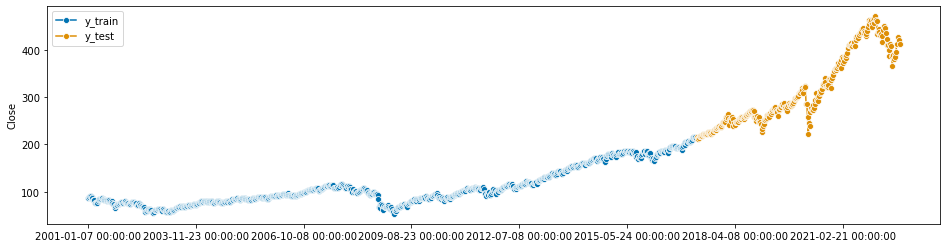

In [58]:
# setting test set size
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

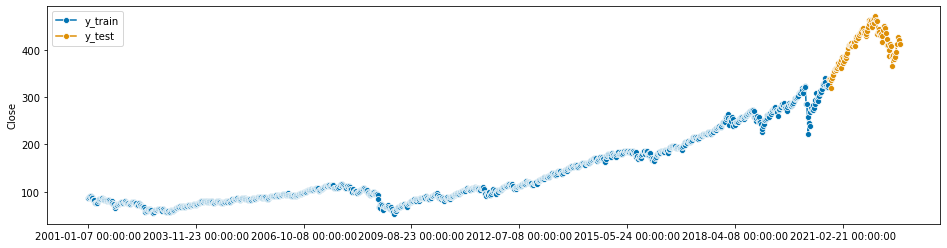

In [61]:
# using forecasting horizon
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(np.arange(1,100))
y_train, y_test = temporal_train_test_split(y, fh=fh)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

# Single window split using `SingleWindowSplitter`
- This class splits the time series once into a training and test window. 
 
*Note that this is very similar to temporal_train_test_split.*

Number of Folds = 1
Length of Train Windows == 50 
 [array([1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061,
       1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072,
       1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083,
       1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094,
       1095, 1096, 1097, 1098, 1099, 1100])]
Length of Test Windows == 29 
 [array([1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111,
       1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122,
       1123, 1124, 1125, 1126, 1127, 1128, 1129])]


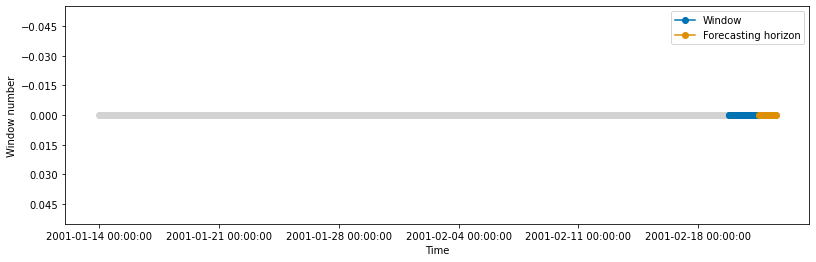

In [63]:
# Define a function to return the test, and training windows like we did above
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

# Import the single window splitter 
from sktime.forecasting.model_selection import SingleWindowSplitter
# set splitter parameters
window_length = 50
fh_array = np.arange(1,30)
# Use forecastinghorizion 
fh = ForecastingHorizon(fh_array)
cv = SingleWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(y)
train_windows, test_windows = get_windows(y, cv)
# Print Number of folds and the length of training and testing windows 
print(f"Number of Folds = {n_splits}")
print(f'Length of Train Windows == {window_length} \n', train_windows)
print(f'Length of Test Windows == {len(fh_array)} \n', test_windows)

plot_windows(y, train_windows, test_windows)

# Sliding windows using `SlidingWindowSplitter`
- This method generates folds that move over time, where the length of both the training and testing sets are constant 

Number of Folds = 17


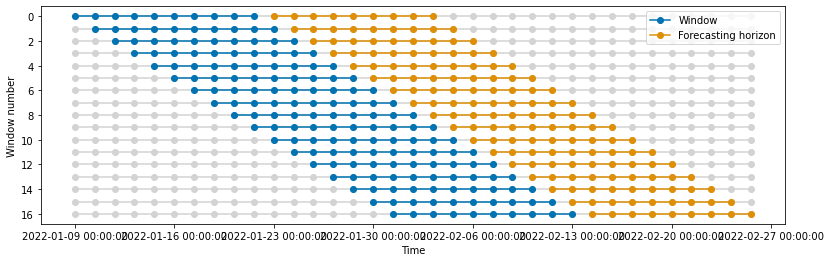

In [95]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
temp_window = y['2022-01-01':].copy()
window_length = 10
fh = ForecastingHorizon(np.arange(1,10))
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(temp_window)
print(f"Number of Folds = {n_splits}")
train_windows, test_windows = get_windows(temp_window, cv)
plot_windows(temp_window, train_windows, test_windows)

### Sliding windows with an __initial window__
- this splitter generates folds which move with time.
- The length of the training and test sets for each fold remains constant.
  - Notice the length of the first window

Number of Folds = 19


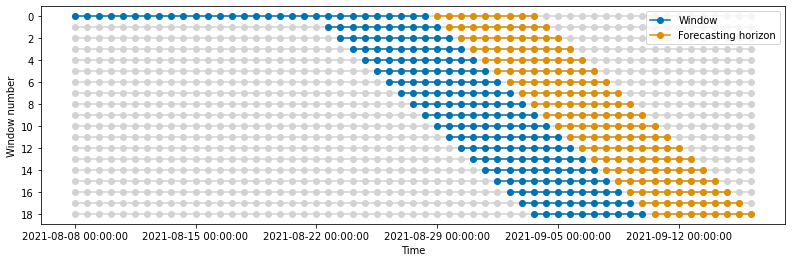

In [102]:
temp_window = y['2021-08-01':].copy()
window_length = 10
fh = ForecastingHorizon(np.arange(1,10))

cv = SlidingWindowSplitter(window_length=window_length, fh=fh, initial_window=30)
n_splits = cv.get_n_splits(temp_window)
print(f"Number of Folds = {n_splits}")
train_windows, test_windows = get_windows(temp_window, cv)
plot_windows(temp_window, train_windows, test_windows)

# Now Expand the windows using `ExpandingWindowSlider`
- This method generates folds which move with time. 
  - The length of the training set each fold grows while test sets for each fold remains constant

Number of Folds = 39


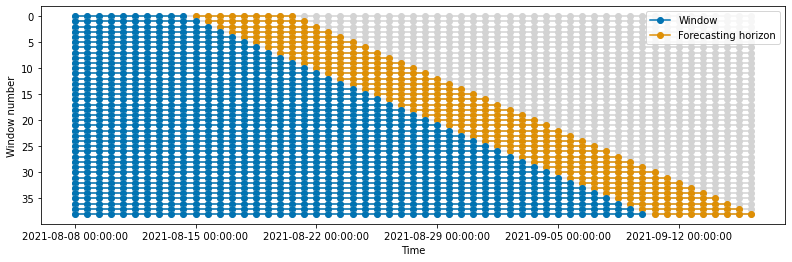

In [111]:
temp_window = y['2021-08-01':].copy()
window_length = 10
fh = ForecastingHorizon(np.arange(1,10))

from sktime.forecasting.model_selection import ExpandingWindowSplitter
cv = ExpandingWindowSplitter(initial_window=window_length, fh=fh)
n_splits = cv.get_n_splits(temp_window)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(temp_window, cv)
plot_windows(temp_window, train_windows, test_windows)

# Finally Multiple splits at specific cutoff values using `CutOffSplitter`
- Manually set specific cut off points 


Number of Folds = 44
Length of Train Windows == 6 
 [array([0, 1]), array([0, 1, 2]), array([0, 1, 2, 3]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4, 5]), array([1, 2, 3, 4, 5, 6]), array([2, 3, 4, 5, 6, 7]), array([3, 4, 5, 6, 7, 8]), array([4, 5, 6, 7, 8, 9]), array([ 5,  6,  7,  8,  9, 10]), array([ 6,  7,  8,  9, 10, 11]), array([ 7,  8,  9, 10, 11, 12]), array([ 8,  9, 10, 11, 12, 13]), array([ 9, 10, 11, 12, 13, 14]), array([10, 11, 12, 13, 14, 15]), array([11, 12, 13, 14, 15, 16]), array([12, 13, 14, 15, 16, 17]), array([13, 14, 15, 16, 17, 18]), array([14, 15, 16, 17, 18, 19]), array([15, 16, 17, 18, 19, 20]), array([16, 17, 18, 19, 20, 21]), array([17, 18, 19, 20, 21, 22]), array([18, 19, 20, 21, 22, 23]), array([19, 20, 21, 22, 23, 24]), array([20, 21, 22, 23, 24, 25]), array([21, 22, 23, 24, 25, 26]), array([22, 23, 24, 25, 26, 27]), array([23, 24, 25, 26, 27, 28]), array([24, 25, 26, 27, 28, 29]), array([25, 26, 27, 28, 29, 30]), array([26, 27, 28, 29, 30, 31]), array([2

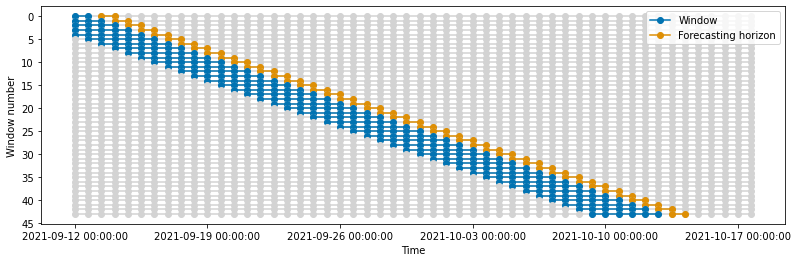

In [142]:
temp_window = y['2021-09-01':].copy()
window_length = 6
fh = ForecastingHorizon(np.arange(1,3))

# Specify cutoff points (by array index).
cutoffs = np.arange(1,45) # ** Only look at these index values ** 

from sktime.forecasting.model_selection import CutoffSplitter
cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(temp_window)
train_windows, test_windows = get_windows(y, cv)
print(f"Number of Folds = {n_splits}")
print(f'Length of Train Windows == {window_length} \n', train_windows)
print(f'Length of Test Windows == {len(fh)} \n', test_windows)
plot_windows(temp_window, train_windows, test_windows)